In [1]:

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
#from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display



In [2]:
root_dir = os.getcwd()
DATA_PATH = os.path.join(root_dir,"darknet/keras-yolo3/data/the-simpsons-characters-dataset")
dataroot = os.path.join(DATA_PATH,"simpsons_dataset")




In [3]:
batch_size=32
image_size=64
dataset = dset.ImageFolder(root=dataroot,transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
]))
workers = 2
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=workers)


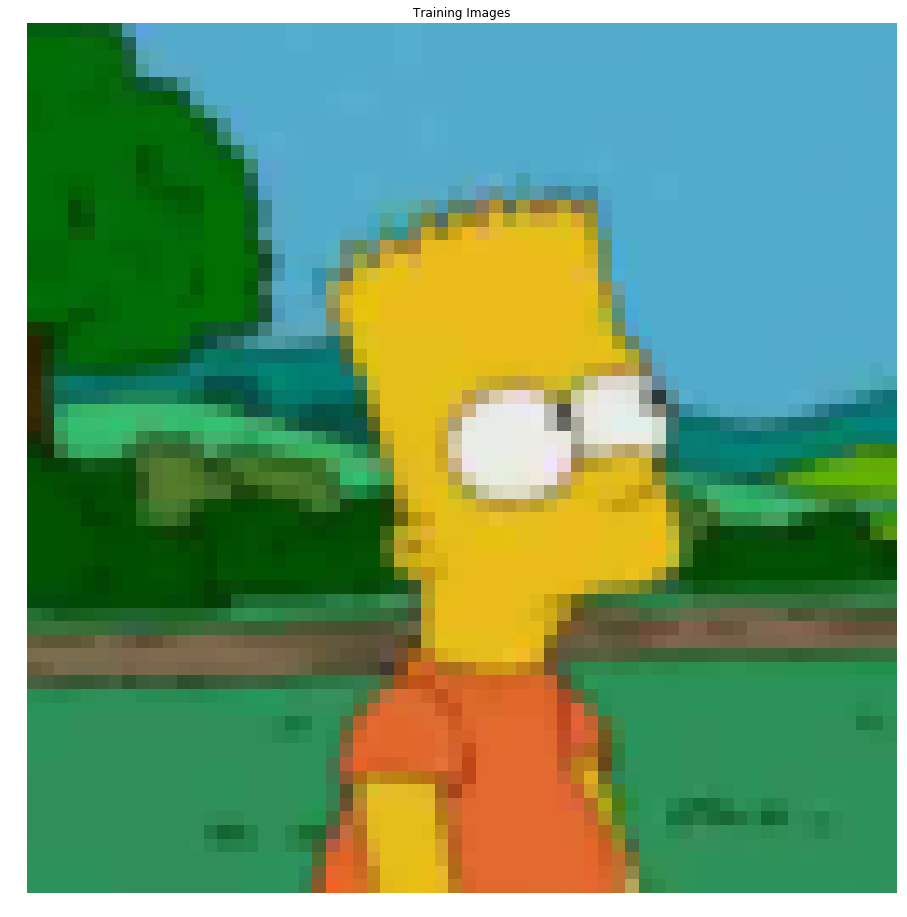

In [4]:
device = torch.device("cpu")
real_batch,_= next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
image = np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2,normalize=True).cpu(),(1,2,0))
plt.imshow(image)



In [5]:
image.shape

torch.Size([64, 64, 3])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        #print(input.size(0))
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    """
    size= img_size*size
    """
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    """
    z_dim connection dim in the bottlenet layer
    
    h_dim = img_size*img_size
    """
    def __init__(self, image_channels=3, h_dim=1024, z_dim=100):
        super(VAE, self).__init__()
        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        #mu layer
        self.fc1 = nn.Linear(h_dim, z_dim)
        #log_var layer
        self.fc2 = nn.Linear(h_dim, z_dim)
        #encoder z->back to img
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar


In [7]:
model = VAE(image_channels=3).to(device)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def loss_fn(recon_x, x, mu, logvar):
    """
    这里的recon_x 是模拟的分布p(z|x)
    """
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    """
    这里是KL散度
    """
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD



In [9]:
epochs = 1
for epoch in range(epochs):
    for idx,(images,_) in enumerate(dataloader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       

        

/home/zhk/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [10]:
torch.save(model.state_dict(),'vae.torch')

In [11]:
fixed_x,_ = next(iter(dataloader))

In [16]:
recon_x,_,_ = model(fixed_x)
compare_x = torch.cat([fixed_x,recon_x])

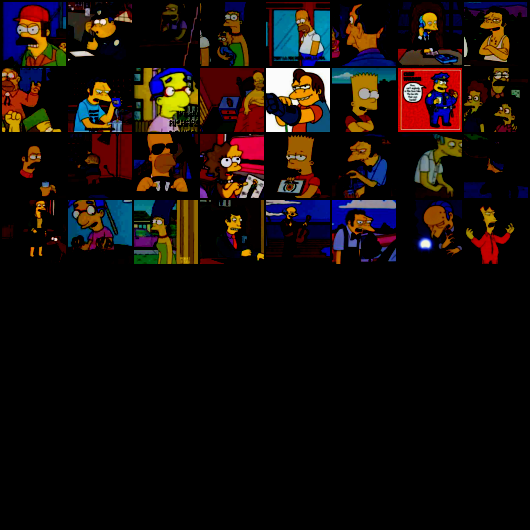

In [17]:
"""

这是跑了一轮的结果，可以多跑几次
"""
save_image(compare_x.data.cpu(),'sample.png')
display(Image('sample.png'))